In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [21]:
train_df = pd.read_csv('home-data-for-ml-course/train.csv')
test_df = pd.read_csv('home-data-for-ml-course/test.csv')

## Exploratory Data Analysis (EDA)

In [22]:
# Проверка пропущенных значений
missing_values = train_df.isnull().sum()
print("Пропущенные значения в тренировочном наборе:\n", missing_values[missing_values > 0].sort_values(ascending=False))

# Типы данных
print("\nТипы данных:\n", train_df.dtypes)

Пропущенные значения в тренировочном наборе:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Типы данных:
 Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


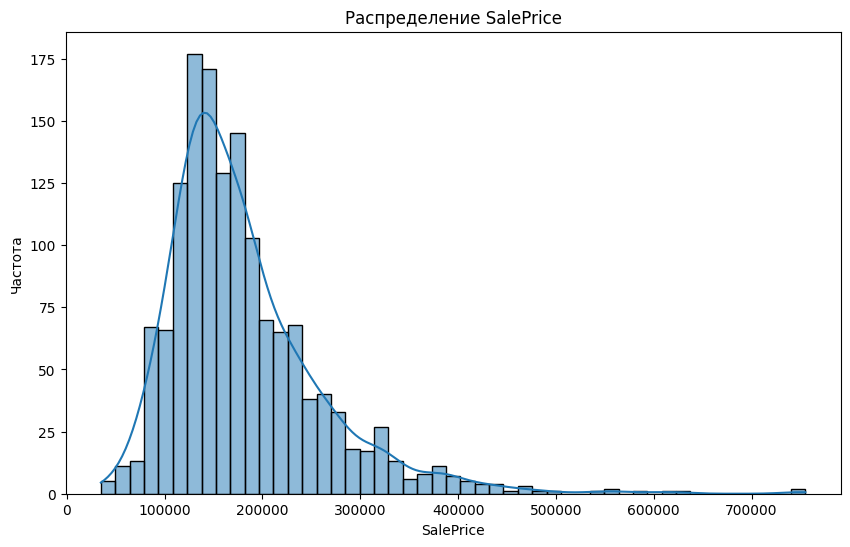

In [23]:
# Распределение целевой переменной (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Распределение SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Частота')
plt.show()

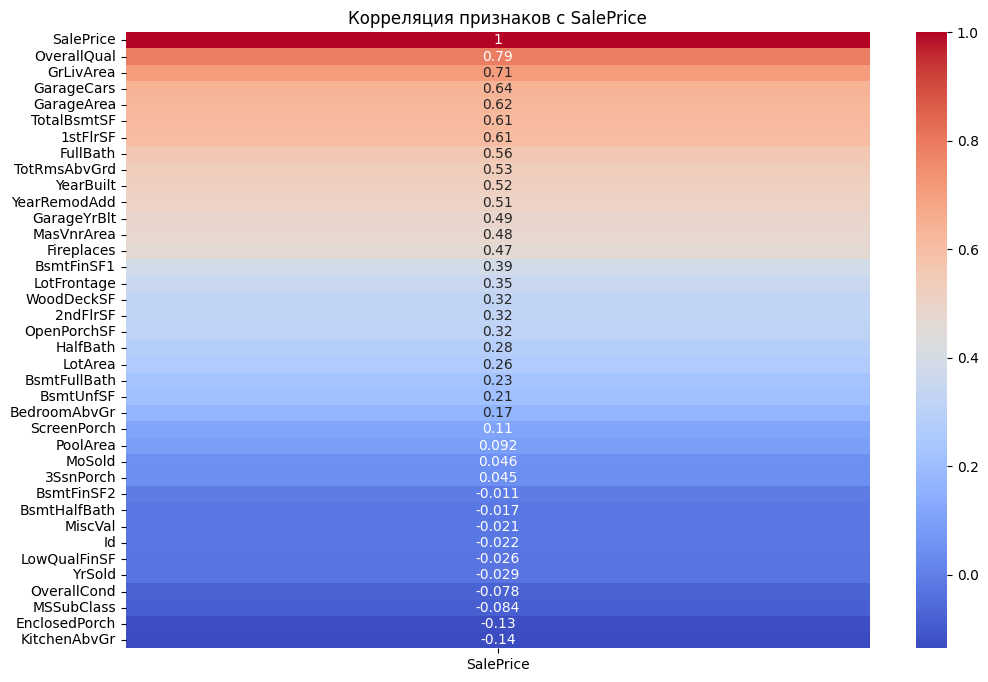

In [24]:
# Корреляция числовых признаков с SalePrice
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков с SalePrice')
plt.show()

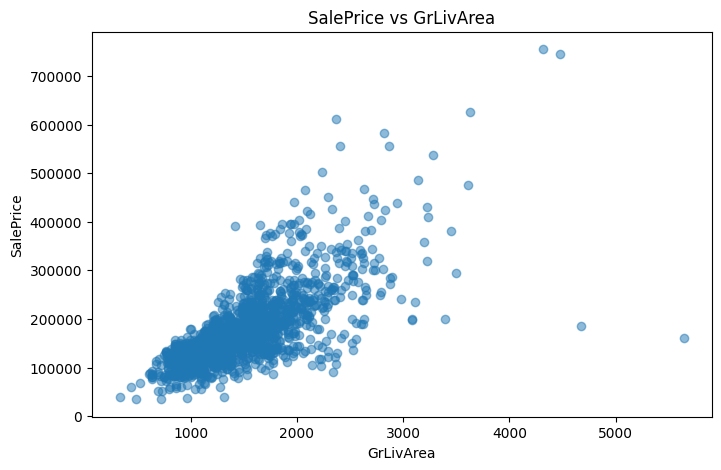

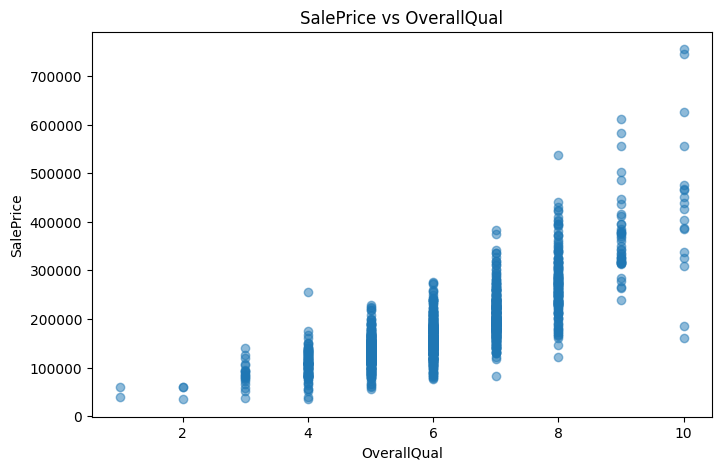

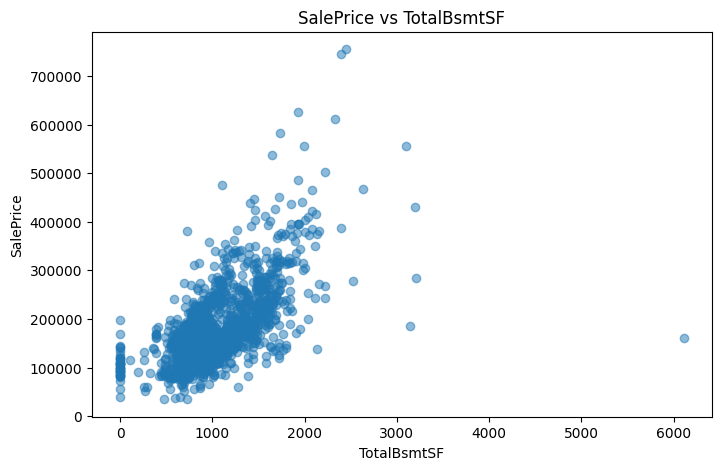

In [25]:
# Визуализация зависимости SalePrice от ключевых признаков
key_features = ['GrLivArea', 'OverallQual', 'TotalBsmtSF']
for feature in key_features:
    plt.figure(figsize=(8, 5))
    plt.scatter(train_df[feature], train_df['SalePrice'], alpha=0.5)
    plt.title(f'SalePrice vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

In [26]:
# Обработка пропущенных значений
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice')
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())
test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].median())

cat_cols = train_df.select_dtypes(include=['object']).columns
train_df[cat_cols] = train_df[cat_cols].fillna('None')
test_df[cat_cols] = test_df[cat_cols].fillna('None')

In [27]:
# Кодирование категориальных признаков
train_encoded = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

# Выравнивание столбцов
train_encoded, test_encoded = train_encoded.align(test_encoded, join='inner', axis=1)

In [34]:
# Подготовка данных для модели
y = np.log1p(train_df['SalePrice'])  # Сохраняем SalePrice до кодирования
X = train_encoded.drop(['Id'], axis=1)
X_test = test_encoded.drop(['Id'], axis=1)

# Выравнивание столбцов
X, X_test = X.align(X_test, join='inner', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Обучение модели XGBoost
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [36]:
# Оценка модели
y_pred_val = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE на валидационной выборке: {val_rmse:.4f}")

RMSE на валидационной выборке: 0.1401


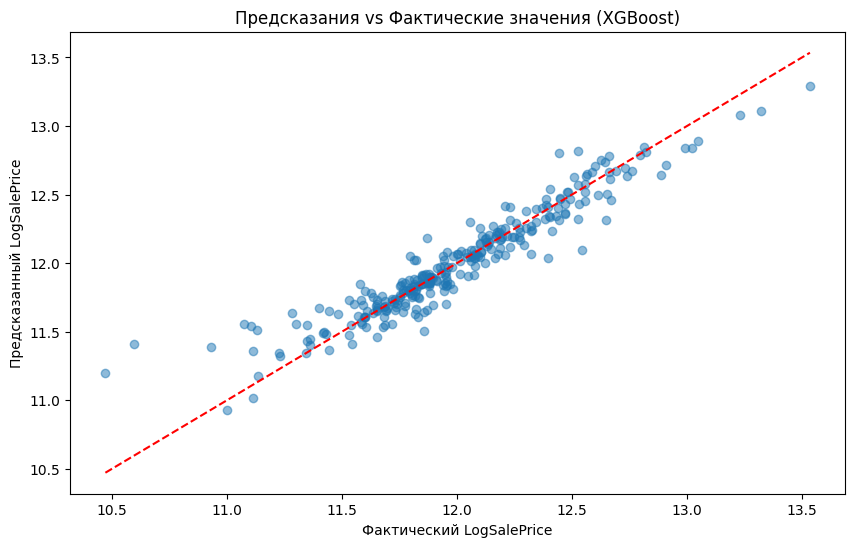

In [37]:
# Визуализация предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Фактический LogSalePrice')
plt.ylabel('Предсказанный LogSalePrice')
plt.title('Предсказания vs Фактические значения (XGBoost)')
plt.show()

In [38]:
# Кросс-валидация
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())
print(f"Средний RMSE по 5-кратной кросс-валидации: {cv_rmse:.4f}")

Средний RMSE по 5-кратной кросс-валидации: 0.1384


In [39]:
# Создание файла для отправки
test_predictions = np.expm1(model.predict(X_test))
submission_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': test_predictions})
submission_df.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно создан")

Файл submission.csv успешно создан
